In [1]:
import os
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import sigmaclip
from scipy.stats import median_abs_deviation

from astropy.table import Table
import astropy.units as u

from lsst.daf.persistence import Butler
# ignore warnings
# import warnings
# warnings.filterwarnings('ignore')

## Functions used to calculate the empirical efficiency

In [3]:
# slice the dataframe with given conditions
def slice_df(df, equal=None, big=None, small=None):
    # condition list
    cond_ls = []
    if equal:
        for key, item in equal.items():
            cond_ls.append(df.loc[:, key]==item)
    if big:
        for key, item in big.items():
            cond_ls.append(df.loc[:, key]>item)
    if small:
        for key, item in small.items():
            cond_ls.append(df.loc[:, key]<item)
    if not cond_ls:
        return df.copy().reset_index(drop=True)
    else:
        index = np.logical_and.reduce(cond_ls)
        sliced_df = df.loc[index].copy().reset_index(drop=True)
        return sliced_df
    
# calculate efficiency
def cal_eff(fake_src):
    detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)].copy().reset_index(drop=True)
    eff = len(detected_fake) / len(fake_src)
    err = np.sqrt(eff * (1-eff)) / len(fake_src)
    return eff, err

# get efficiencies for all host mags at given fake mags
def get_efficiency(fake_src_df, host_mag_list=None, fake_mag_list=None):
    eff_dict, err_dict = {}, {}
    for host_mag in host_mag_list:
        efficiency_list = []
        err_list = []
        for fake_mag in fake_mag_list:
            fake_mag_str = str(fake_mag).replace('.', '')
            fake_src = slice_df(fake_src_df, equal={'host_mag': host_mag, 'fake_mag': fake_mag_str})
            eff, err = cal_eff(fake_src)
            efficiency_list.append(eff)
            err_list.append(err)
        eff_dict[host_mag] = efficiency_list
        err_dict[host_mag] = err_list
    return eff_dict, err_dict


## Functions used to calculate the theoretical efficiency

In [4]:
# estimate the mean variance of an exposure (unit: instFlux^2)
def estimate_var(exp): 
    # get the variance plane
    var_arr = exp.getVariance().array
    # remove infinite value and nan value
    inf_idx = np.isinf(var_arr)
    nan_idx = np.isnan(var_arr)
    remove_idx = np.logical_or(inf_idx, nan_idx)
    keep_idx = remove_idx == False
    var_remove = var_arr[keep_idx].copy()
    # remove outliers
    var_clipped, _, _ = sigmaclip(var_remove)
    var = np.median(var_clipped)
    return var

# convert mags to fluxes with a given photoCalib (unit: number of electrons)
def convert_to_flux(mag_arr, photo_calib):
    gain = 0.7
    arr_length = len(mag_arr)
    flux_list = []
    for mag in mag_arr:
        flux = photo_calib.magnitudeToInstFlux(mag) * gain
        flux_list.append(flux)
    return flux_list

# calculate the median fluxes (unit: number of electrons)
def cal_median_flux(mag_arr, calexp_butler, calexp_info):
    full_flux_list = []
    for idx, row in calexp_info.iterrows():
        # get calexp id
        visit = int(row['visit'])
        filt = str(row['filter'])
        detector = int(row['detector'])
        data_id = {'visit': visit, 'filter': filt, 'detector': detector}
        # get photoCalib
        photo_calib = calexp_butler.get('calexp_photoCalib',  data_id)
        flux_list = convert_to_flux(mag_arr, photo_calib)
        full_flux_list.append(flux_list)
    full_flux_arr = np.array(full_flux_list)
    median_flux_arr = np.median(full_flux_arr, axis=0)
    return median_flux_arr

# calculate the median sky variance (unit: number of electrons)
def cal_sky_var(calexp_butler, calexp_info):
    gain = 0.7
    var_arr = np.zeros(len(calexp_info))
    for idx, row in calexp_info.iterrows():
        # get calexp id
        visit = int(row['visit'])
        filt = str(row['filter'])
        detector = int(row['detector'])
        data_id = {'visit': visit, 'filter': filt, 'detector': detector}
        exposure = calexp_butler.get('calexp', dataId=data_id)
        # psf = exposure.getPsf().computeImage().array.ravel()
        var = estimate_var(exposure) * gain * gain
        var_arr[idx] = var
    return np.median(var_arr)

## Get the empirical efficiency

In [8]:
# get the detection information of the fake source
default_db = (
    f'/global/cscratch1/sd/shl159/projects/dia_improvement/data'
    f'/patch_0to6/diff/perfect/al_default/detection/detection.sqlite'
)
conn = sqlite3.connect(default_db)
default_flux = pd.read_sql_query('SELECT * FROM fake_src', conn)

In [9]:
host_mag_list = ['20_21', '21_22', '22_23', '23_24', '24_25']
fake_mag_list = [20, 21, 22, 23, 24]
# get the empirical efficiency and error
eff_dict, err_dict = get_efficiency(default_flux, host_mag_list, fake_mag_list)

## Get the theoretical efficiency

In [7]:
# get information of the calexp exposures
conn = sqlite3.connect('../data/table/gal_4639/injection_coord.sqlite')
calexp_info_query = (f'SELECT distinct(visit), filter, detector, patch_1, patch_2, tract FROM injection_coord')
calexp_info = pd.read_sql_query(calexp_info_query, conn)

# get butler
COADD_REPO = ('/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-grizy')
CALEXP_REPO = ('/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-calexp-v1')
coadd_butler = Butler(COADD_REPO)
calexp_butler = Butler(CALEXP_REPO)

/tmp/ipykernel_34708/1059757991.py:9: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  coadd_butler = Butler(COADD_REPO)
/tmp/ipykernel_34708/1059757991.py:9: FutureWarning: Gen2 Butler has been deprecated (ImsimMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  coadd_butler = Butler(COADD_REPO)


CameraMapper INFO: Loading exposure registry from /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/registry.sqlite3
CameraMapper INFO: Loading calib registry from /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/CALIB/calibRegistry.sqlite3
CameraMapper INFO: Loading calib registry from /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/CALIB/calibRegistry.sqlite3
LsstCamMapper WARN: Unable to find valid calib root directory
CameraMapper INFO: Loading exposure registry from /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/registry.sqlite3
CameraMapper INFO: Loading calib registry from /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/CALIB/calibRegistry.sqlite3
CameraMapper INFO: Loading calib registry from /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/CALIB/calibRegistry.sqlite3


In [10]:
# calculate host median flux (unit: number of electrons)
# in the number of electrons unit, the host flux is equal to its variance
host_mag_arr = np.array([20.5, 21.5, 22.5, 23.5, 24.5])
host_median_flux = cal_median_flux(host_mag_arr, calexp_butler, calexp_info)

# calculate fake median flux (unit: number of electrons)
fake_mag_arr = np.arange(18, 25, 0.1)
fake_median_flux = cal_median_flux(fake_mag_arr, calexp_butler, calexp_info)

In [16]:
# calculate sky variance (unit: number of electrons)
# sky_var = cal_sky_var(calexp_butler, calexp_info)
print('sky variance: ', sky_var)
# To avoid replicated calculation, we set the sky variance directly
sky_var = 1463.3723791503903

sky variance:  1463.3723791503903


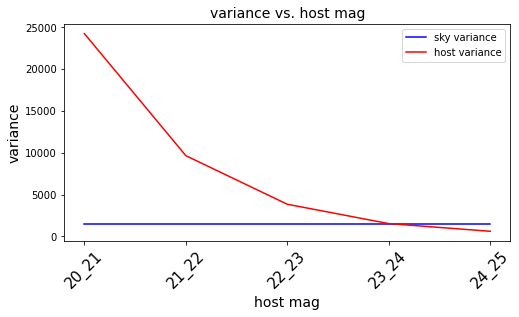

In [17]:
# take a look of the variance
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(np.arange(5), np.repeat(sky_var, 5), color='b', label='sky variance')
ax.plot(np.arange(5), host_median_flux, color='r', label='host variance')
ax.set_xlabel('host mag',size=14)
ax.set_xticks(np.arange(5))
ax.set_xticklabels(host_mag_list, size=15, rotation=45)
ax.set_ylabel('variance',size=14)
ax.set_title('variance vs. host mag',size=14)
ax.legend()
print()

In [18]:
# the detection status of the fake source should obey the Bernoulli distribution
# calculate the efficiency, which equals the area under the cdf curve starting from 5 to infinity
def cal_theory_eff(s2n):
    rv = norm(s2n)
    return 1 - rv.cdf(5)

In [29]:
# free parameters used to fit the theory to data
sky_scale = 80
host_scale = 2

host_len = len(host_median_flux)
fake_len = len(fake_median_flux)
eff_theory_arr = np.zeros((host_len, fake_len))
for host_idx, host_flux in enumerate(host_median_flux):
    for fake_idx, fake_flux in enumerate(fake_median_flux):
        signal = fake_flux
        # calculate the variance
        variance = sky_var * sky_scale  + host_flux * host_scale
        s2n = signal / np.sqrt(variance)
        eff = cal_theory_eff(s2n)
        eff_theory_arr[host_idx][fake_idx] = eff


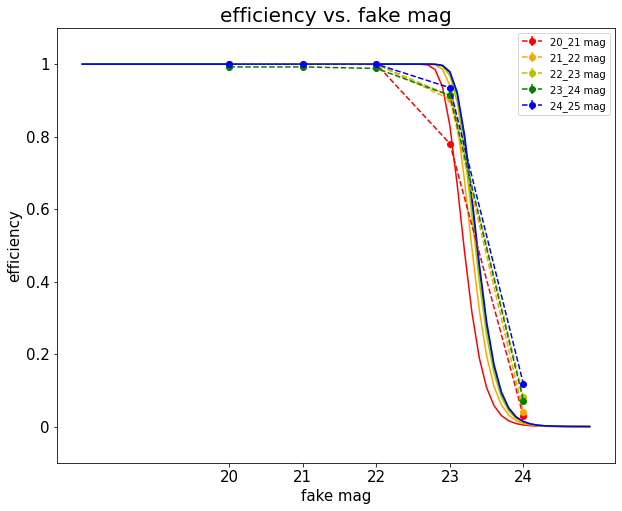

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
fig.subplots_adjust(hspace=0.3)
# plot_efficiency(ax, eff_dict, err_dict, 'efficiency vs. fake mag', host_mag_list, fake_mag_list)

color_list = ['r', 'orange', 'y', 'g', 'blue']

for host_idx, host_mag in enumerate(host_mag_list):
    color = color_list[host_idx]
    eff_theory = eff_theory_arr[host_idx]
    # plot the empirical efficiency
    ax.errorbar(fake_mag_list, eff_dict[host_mag], yerr=err_dict[host_mag],
                marker='o', ls='--', color=color, label=host_mag + " mag")
    # plot the theoretical efficiency
    ax.plot(fake_mag_arr, eff_theory, ls='-', color=color)
ax.set_xticks(fake_mag_list)
ax.set_xticklabels(fake_mag_list, size=15)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], size=15)
ax.set_ylim((-0.1, 1.1))
ax.set_xlabel('fake mag', size=15)
ax.set_ylabel('efficiency', size=15)
ax.set_title('efficiency vs. fake mag', size=20)
ax.legend()